In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import sys
sys.path.append("../../autotalker")
sys.path.append("../utils")

In [196]:
import os

import anndata as ad
import matplotlib.pyplot as plt
import scanpy as sc
import scib
import scvi
import squidpy as sq

from autotalker.benchmarking import compute_clisis, compute_cas
from autotalker.models import Autotalker
from autotalker.utils import get_gene_annotations, generate_multimodal_pairing_dict, add_multimodal_mask_to_adata
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

from color_utils import (latent_cluster_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors)

### 1.2 Define Parameters

In [31]:
nichenet_keep_target_genes_ratio = 0.01
nichenet_max_n_target_genes_per_gp = 25344
include_mebocost_gps = True
mebocost_species = "mouse"
filter_genes = True
gp_filter_mode = "subset"
combine_overlap_gps = True
overlap_thresh_source_genes = 0.9
overlap_thresh_target_genes = 0.9
overlap_thresh_genes = 0.9
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
gp_names_key = "autotalker_gp_names"
cond_embed_injection = ["gene_expr_decoder"]
active_gp_names_key = "autotalker_active_gp_names"
latent_key = "autotalker_latent"
active_gp_thresh_ratio = 0.05
gene_expr_recon_dist = "nb"
n_layers_encoder = 1
conv_layer_encoder = "gcnconv"
log_variational = True
node_label_method = "one-hop-attention"
filter_peaks = True
min_cell_peak_thresh_ratio = 0.002 # 0.2%
n_epochs = 10
n_epochs_all_gps = 10
n_epochs_no_cond_contrastive = 0
lr = 0.001
lambda_edge_recon = 1000.
lambda_gene_expr_recon = 1.
lambda_cond_contrastive = 0.
contrastive_logits_ratio = 0.015625
lambda_group_lasso = 0.
lambda_l1_masked = 0.
edge_batch_size = 128
node_batch_size = None
mlflow_experiment_id = None

In [5]:
srt_data_gold_folder_path = "../datasets/srt_data/gold"
figure_folder_path = f"../figures"
ga_data_folder_path = "../datasets/ga_data"
gp_data_folder_path = "../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"
gtf_file_path = ga_data_folder_path + "/gencode.vM32.chr_patch_hapl_scaff.annotation.gtf.gz"

# Create required directories
os.makedirs(gp_data_folder_path, exist_ok=True)
os.makedirs(srt_data_gold_folder_path + "/results", exist_ok=True)

## 2. Autotalker Model

### 2.1 Prepare Gene Program Mask

In [6]:
print("Preparing the gene program mask...")
# OmniPath gene programs
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path,
    plot_gp_gene_count_distributions=False)

omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

# NicheNet gene programs
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=nichenet_keep_target_genes_ratio,
    max_n_target_genes_per_gp=nichenet_max_n_target_genes_per_gp,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=False)

nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

# Combine gene programs into one dictionary
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

if filter_genes:
    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + nichenet_source_genes))

# Mebocost gene programs
if include_mebocost_gps:
    mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species=mebocost_species,
    genes_uppercase=True,
    plot_gp_gene_count_distributions=False)
    
    mebocost_genes = get_unique_genes_from_gp_dict(
        gp_dict=mebocost_gp_dict,
        retrieved_gene_entities=["sources", "targets"])

    combined_gp_dict.update(mebocost_gp_dict)
    
    if filter_genes:
        # Update gene program relevant genes
        gp_relevant_genes = list(set(gp_relevant_genes + mebocost_genes))
    
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode=gp_filter_mode,
    combine_overlap_gps=combine_overlap_gps,
    overlap_thresh_source_genes=overlap_thresh_source_genes,
    overlap_thresh_target_genes=overlap_thresh_target_genes,
    overlap_thresh_genes=overlap_thresh_genes,
    verbose=False)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Preparing the gene program mask...
Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1575.


In [122]:
dataset = "spatial_atac_rna_seq_mouse_embryo_and_brain_batch1"
spatial_key = "spatial"
n_neighbors = 12
adj_key = "spatial_connectivities"
n_hvg = 2000
counts_key = "counts"
condition_key = "batch"

In [123]:
adata = sc.read_h5ad(
        f"{srt_data_gold_folder_path}/{dataset}_rna.h5ad")
adata_atac = sc.read_h5ad(
        f"{srt_data_gold_folder_path}/{dataset}_atac.h5ad")

# TEMP DELETE
adata.layers["counts"] = adata.X
adata_atac.layers["counts"] = adata_atac.X
adata.obs["batch"] = "e13"
adata_atac.obs["batch"] = "e13"

# Compute (separate) spatial neighborhood graphs
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)
# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

In [124]:
if filter_genes:
    print("\nFiltering genes...")
    # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    if counts_key is not None:
        hvg_layer = counts_key
        if (adata.layers[counts_key].astype(int).sum() == 
        adata.layers[counts_key].sum()): # raw counts
            hvg_flavor = "seurat_v3"
        else: # log normalized counts
            hvg_flavor = "seurat"
    else:
        hvg_layer = None
        if adata.X.astype(int).sum() == adata.X.sum():
        # raw counts
            hvg_flavor = "seurat_v3"
        else: # log normalized counts
            hvg_flavor = "seurat"

    sc.pp.highly_variable_genes(
        adata,
        layer=hvg_layer,
        n_top_genes=n_hvg,
        flavor=hvg_flavor,
        batch_key=condition_key,
        subset=False)

    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
                gp_dict_genes)].sort_values()])
    print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
          "gp dict.")
    
if filter_peaks:
    print("\nFiltering peaks...")
    print(f"Starting with {len(adata_atac.var_names)} peaks.")
    # Filter out peaks that are rarely detected to reduce GPU footprint of model
    min_cells = int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)
    sc.pp.filter_genes(adata_atac, min_cells=min_cells)
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
          f"counts in less than {int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)} cells.")


Filtering genes...
Starting with 20900 genes.
Keeping 20900 genes after filtering genes with expression in 0 cells.
Keeping 3953 highly variable or gene program relevant genes.
Keeping 3570 genes after filtering genes not in gp dict.

Filtering peaks...
Starting with 44511984 peaks.
Keeping 13126 peaks after filtering peaks with counts in less than 4 cells.


In [125]:
adata, adata_atac = get_gene_annotations(
    adata=adata,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

In [126]:
# Add the gene program dictionary as binary masks to the adata for model 
# training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    filter_genes_not_in_masks=False)

In [127]:
gene_peak_dict = generate_multimodal_pairing_dict(
    adata,
    adata_atac)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:253: ResourceWarning: unclosed file <_io.BufferedReader name=68>
  for inst in _active[:]:
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:253: ResourceWarning: unclosed file <_io.BufferedReader name=70>
  for inst in _active[:]:
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:765: ResourceWarning: unclosed file <_io.BufferedReader name=69>
  _cleanup()
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:765: ResourceWarning: unclosed file <_io.BufferedReader name=72>
  _cleanup()
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:1052: ResourceWarning: subprocess 15724 is still running
  _warn("subprocess %s is still running" % self.pid,
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:1052: ResourceWarning: subprocess 15725 is still running
  _warn("subprocess %s is still running" % self.pid,


window_graph:   0%|          | 0/3531 [00:00<?, ?it/s]

In [128]:
adata_atac = add_multimodal_mask_to_adata(
    adata=adata,
    adata_atac=adata_atac,
    gene_peak_mapping_dict=gene_peak_dict)

In [129]:
import pickle

# Open the file in write binary mode
with open("gene_peak_dict", "wb") as file:
    # Dump the dictionary to the file
    pickle.dump(gene_peak_dict, file)
    
# Open the file in write binary mode
with open("combined_new_gp_dict", "wb") as file:
    # Dump the dictionary to the file
    pickle.dump(combined_new_gp_dict, file)
    
adata.write("adata.h5ad")
adata_atac.write("adata_atac.h5ad")

In [130]:
# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

# Determine dimensionality of conditional embedding (in case injected)
n_cond_embed = len(adata.uns[gp_names_key])

In [181]:
1 / 0

ZeroDivisionError: division by zero

In [182]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

In [183]:
print("\nTraining model...")
# Initialize model
model = Autotalker(adata,
                   adata_atac,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=cond_embed_injection,
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_layers_encoder=n_layers_encoder,
                   conv_layer_encoder=conv_layer_encoder,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational,
                   node_label_method=node_label_method)


Training model...
--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.05
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder']
ENCODER -> n_input: 4649, n_cond_embed_input: 0, n_layers: 1, n_hidden: 1470, n_latent: 1470, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 1470, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1470, n_cond_embed_input: 1470, n_addon_input: 0, n_output: 7062
MASKED CHROMATIN ACCESSIBILITY DECODER -> n_input: 1470, n_cond_embed_input: 0, n_addon_input: 0, n_output: 2236
ONE HOP ATTENTION NODE LABEL AGGREGATOR -> n_input: 4649, n_heads: 4, self_loops: True


In [189]:
lambda_edge_recon = 0.
lambda_gene_expr_recon = 0.
lambda_chrom_access_recon = 1000.
n_epochs = 1

In [191]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            n_epochs_no_cond_contrastive=n_epochs_no_cond_contrastive,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_chrom_access_recon=lambda_chrom_access_recon,
            lambda_cond_contrastive=lambda_cond_contrastive,
            contrastive_logits_ratio=contrastive_logits_ratio,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=mlflow_experiment_id,
            verbose=True)


--- INITIALIZING TRAINER ---
Number of training nodes: 1968
Number of validation nodes: 219
Number of training edges: 12308
Number of validation edges: 1367

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% val_auroc_score: 0.5000; val_auprc_score: 0.5000; val_best_acc_score: 0.5000; val_best_f1_score: 0.6667; train_kl_reg_loss: 0.0002; train_edge_recon_loss: 0.0000; train_gene_expr_recon_loss: 0.0000; train_masked_gp_l1_reg_loss: 0.0000; train_group_lasso_reg_loss: 0.0000; train_chrom_access_recon_loss: 56228.4186; train_global_loss: 0.0002; train_optim_loss: 0.0002; val_kl_reg_loss: 0.0001; val_edge_recon_loss: 0.0000; val_gene_expr_recon_loss: 0.0000; val_masked_gp_l1_reg_loss: 0.0000; val_group_lasso_reg_loss: 0.0000; val_chrom_access_recon_loss: 5.4714; val_global_loss: 0.0001; val_optim_loss: 0.0001

Model training finished after 0 min 10 sec.
Using best model state, which was in epoch 1.

--- MODEL EVALUATION ---
Val AUROC score: 0.5000
Val AUPRC score: 0.5000
Val

In [199]:
sc.pp.neighbors(model.adata,
                use_rep=latent_key)
sc.tl.umap(model.adata)
sc.tl.leiden(model.adata,
             resolution=1.)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


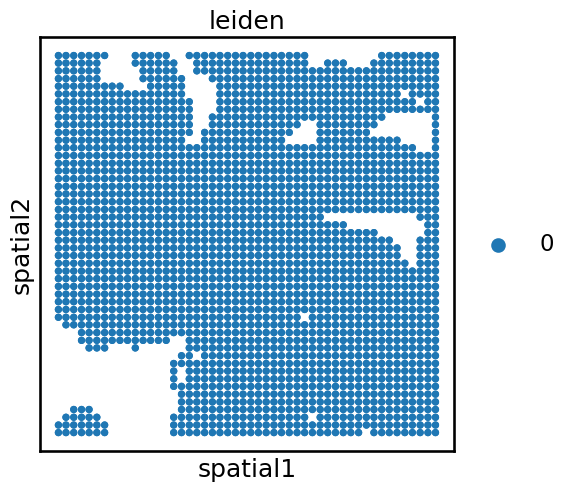

In [200]:
del(adata.uns["leiden_colors"])
sq.pl.spatial_scatter(model.adata, color="leiden", shape=None)        

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'One-Shot Integration: Latent Space Cell Type Annotations')

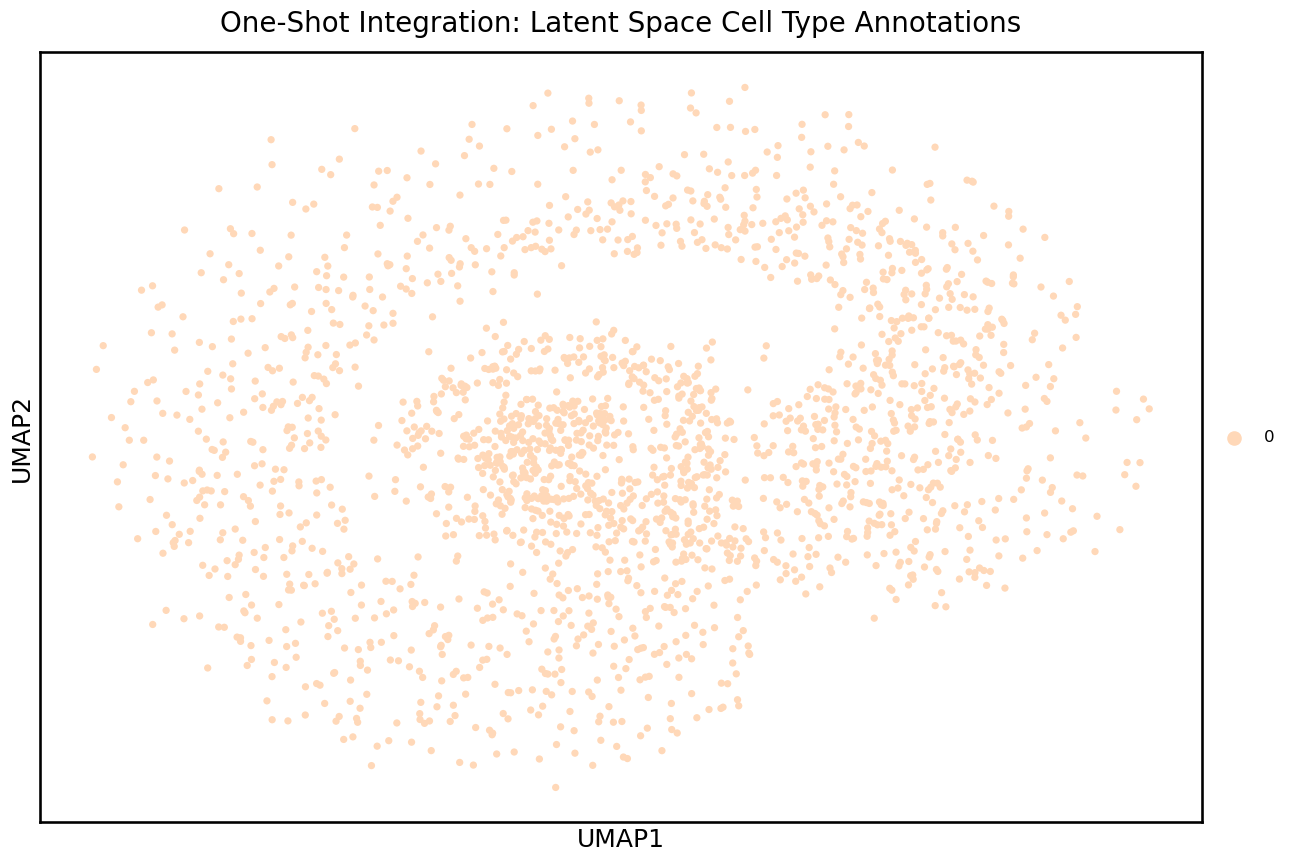

In [201]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 #groups="Allantois",
                 color=["leiden"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

In [ ]:
sq.pl.spatial_scatter(model.adata, color="RNA_clusters", shape=None)        

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'One-Shot Integration: Latent Space Cell Type Annotations')

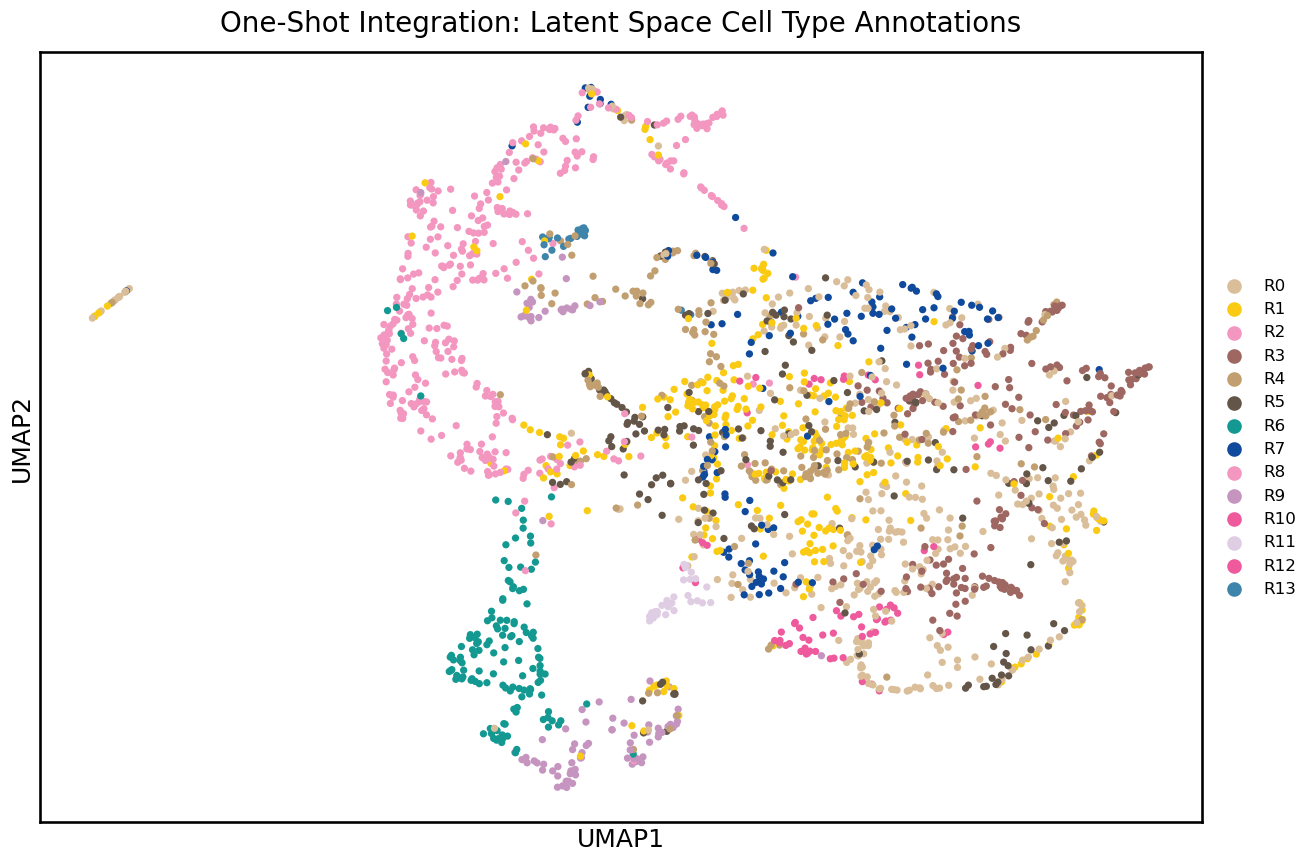

In [137]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 #groups="Allantois",
                 color=["RNA_clusters"],
                 palette=spatial_atac_rna_seq_mouse_embryo_and_brain_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


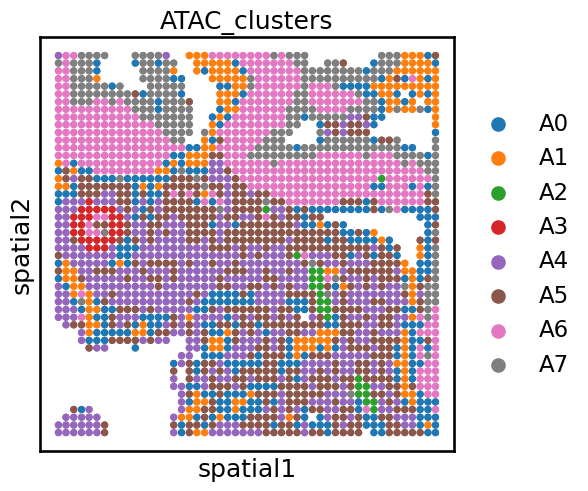

In [192]:
sq.pl.spatial_scatter(model.adata, color="ATAC_clusters", shape=None)        

In [195]:
model.adata.obs["ATAC_clusters"].unique()

['A0', 'A4', 'A5', 'A1', 'A6', 'A7', 'A2', 'A3']
Categories (8, object): ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'One-Shot Integration: Latent Space Cell Type Annotations')

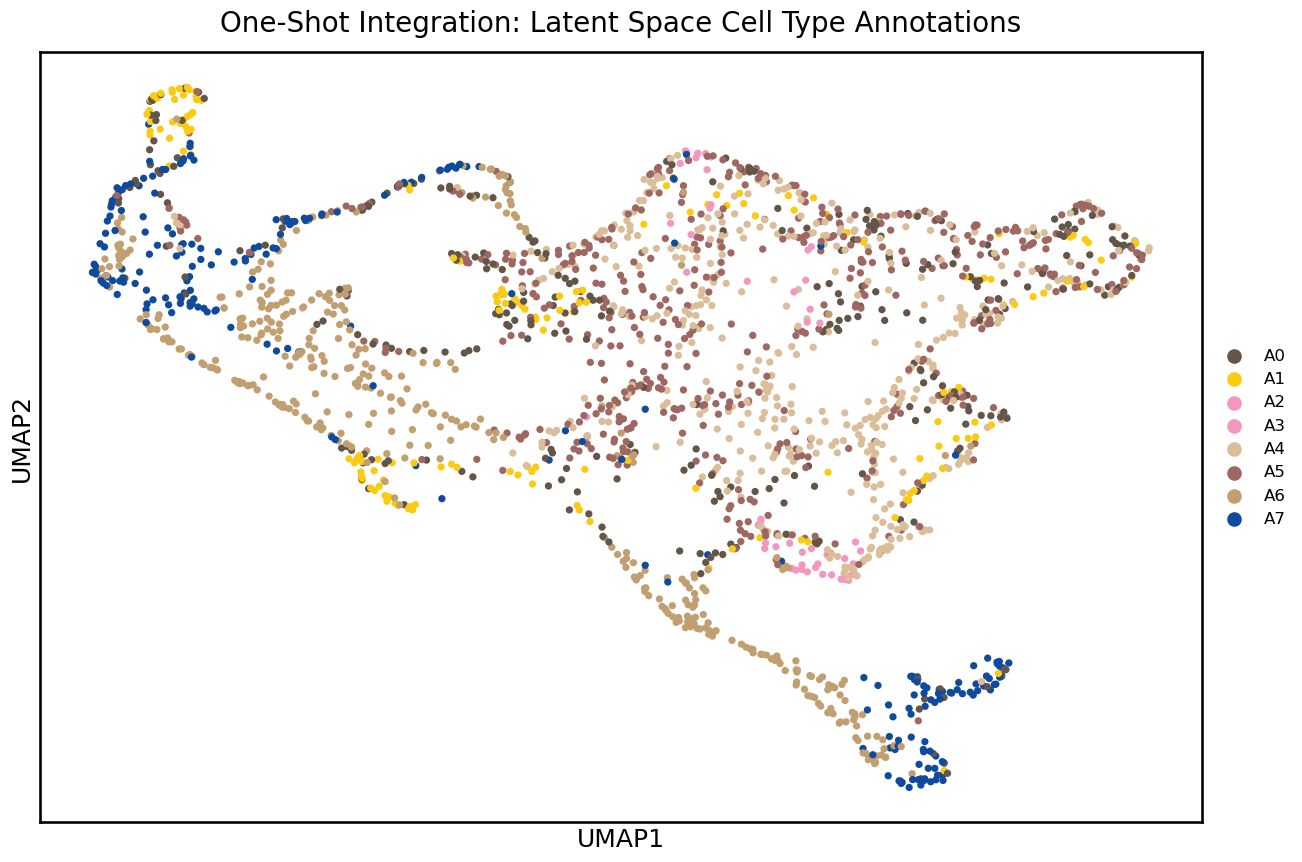

In [197]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 #groups="Allantois",
                 color=["ATAC_clusters"],
                 palette=spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

# SCVI

In [94]:
# Setup adata
scvi.model.SCVI.setup_anndata(adata,
                              layer=counts_key,
                              batch_key=condition_key)

# Initialize model
# Use hyperparams that provenly work well on integration tasks
model = scvi.model.SCVI(adata,
                        n_layers=2,
                        n_latent=30,
                        gene_likelihood="nb")

# Train model
model.train()

# Store latent representation
adata.obsm["scvi_latent"] = model.get_latent_representation()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████| 400/400 [00:46<00:00,  8.65it/s, loss=4e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████| 400/400 [00:46<00:00,  8.63it/s, loss=4e+03, v_num=1]


In [106]:
sc.pp.neighbors(adata,
                use_rep="scvi_latent")
sc.tl.umap(adata)
sc.tl.leiden(adata=adata,
             resolution=1.)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'One-Shot Integration: Latent Space Cell Type Annotations')

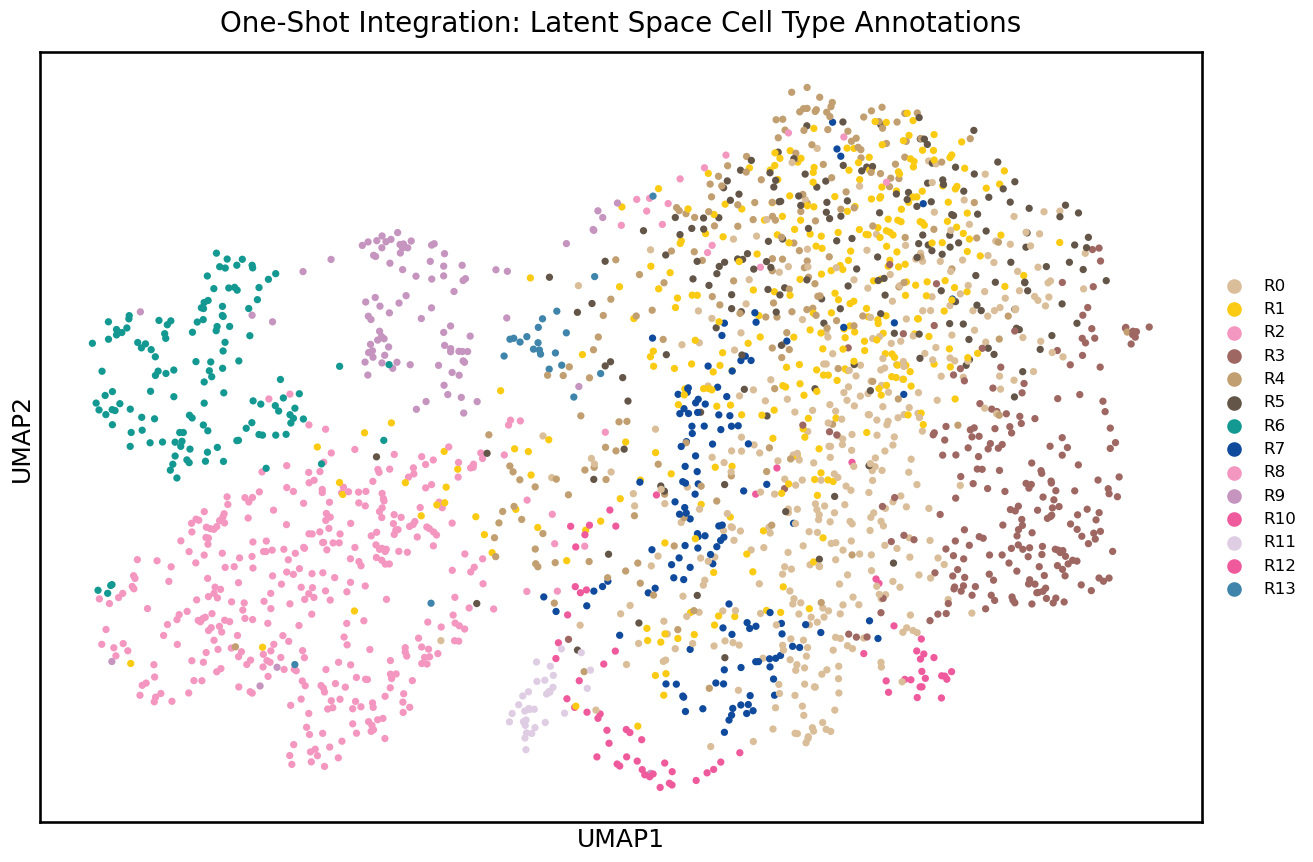

In [107]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 #groups="Allantois",
                 color=["RNA_clusters"],
                 palette=spatial_atac_rna_seq_mouse_embryo_and_brain_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'One-Shot Integration: Latent Space Cell Type Annotations')

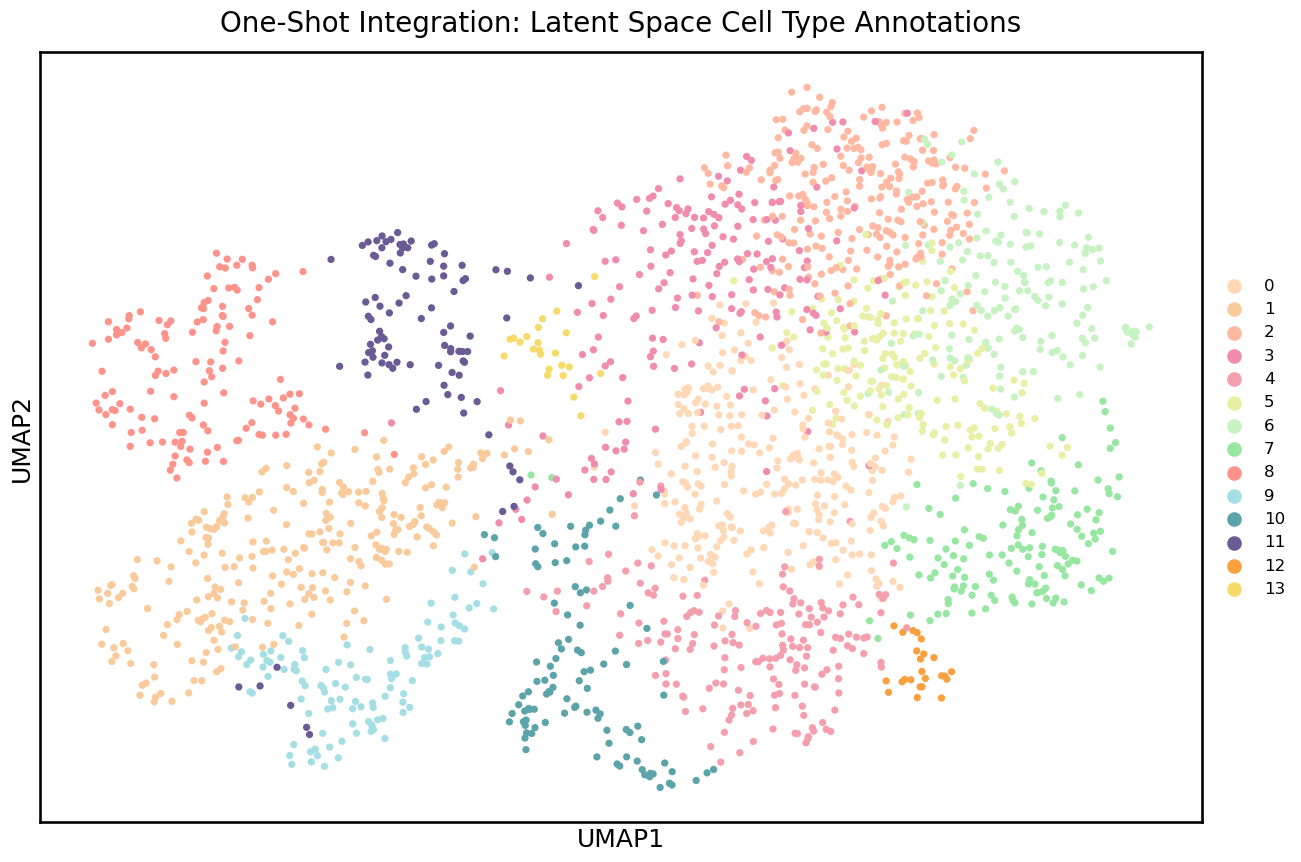

In [108]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 #groups="Allantois",
                 color=["leiden"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


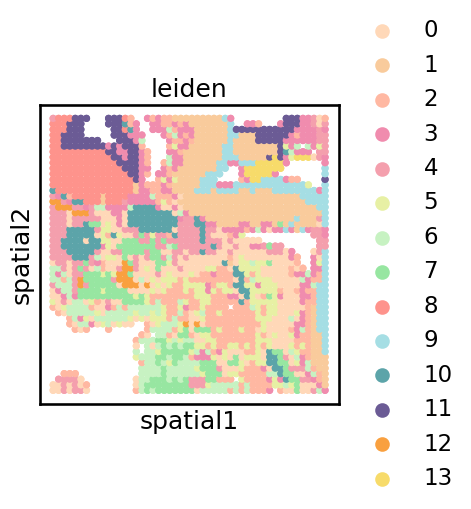

In [109]:
sq.pl.spatial_scatter(adata, color="leiden", shape=None)        

In [120]:
del(adata.uns["RNA_clusters_colors"])

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


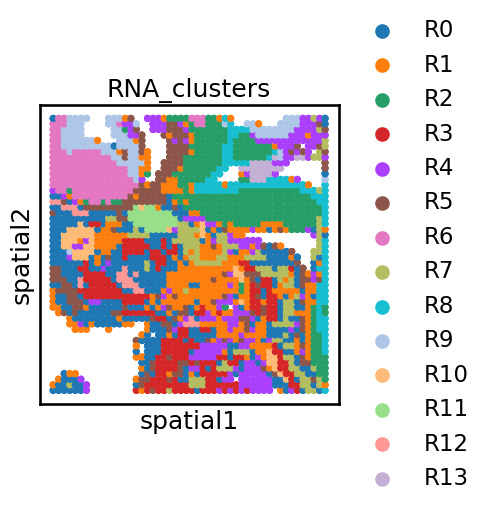

In [121]:
sq.pl.spatial_scatter(adata,
                      color="RNA_clusters",
                      shape=None)        

In [110]:
adata.obs["leiden"]

ACAAGCTAAAGACGGA    2
ACAAGCTAAAGGTACA    6
ACAAGCTAACACAGAA    6
ACAAGCTAACAGCAGA    6
ACAAGCTAACCTCCAA    7
                   ..
CGCTGATCGAATCTGA    5
CGCTGATCCAAGACTA    2
CGCTGATCGAGCTGAA    1
CGCTGATCGATAGACA    1
CGCTGATCGCCACATA    9
Name: leiden, Length: 2187, dtype: category
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']

In [113]:
adata.obs["RNA_clusters"]

ACAAGCTAAAGACGGA    R5
ACAAGCTAAAGGTACA    R0
ACAAGCTAACACAGAA    R0
ACAAGCTAACAGCAGA    R0
ACAAGCTAACCTCCAA    R0
                    ..
CGCTGATCGAATCTGA    R5
CGCTGATCCAAGACTA    R1
CGCTGATCGAGCTGAA    R2
CGCTGATCGATAGACA    R2
CGCTGATCGCCACATA    R8
Name: RNA_clusters, Length: 2187, dtype: category
Categories (14, object): ['R0', 'R1', 'R2', 'R3', ..., 'R10', 'R11', 'R12', 'R13']